In [1]:
%matplotlib inline
from fastai.basics import *

# Load the file

Load the pickle file for mnist dataset.

In [5]:
path = Config().data_path()/'mnist'

In [6]:
path.ls()

[PosixPath('/home/vishaladu/.fastai/data/mnist/mnist.pkl.gz')]

In [7]:
with gzip.open(path/'mnist.pkl.gz') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

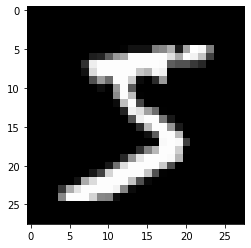

In [12]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
x_train.shape

In [13]:
#map np objects to pytorch tensors
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [15]:
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [17]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [18]:
x,y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

# Create Logistic Regression class

This is a neural net with 1 layer (0 hidden layers). This is also called logistic regression.

In [19]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
        
    def forward(self, xb): return self.lin(xb)

In [20]:
model = Mnist_Logistic().cuda()

In [21]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [22]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [24]:
model(x).shape

torch.Size([64, 10])

In [25]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [26]:
lr = 2e-2

In [27]:
loss_func = nn.CrossEntropyLoss()

In [28]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    
    #weight decay
    w2 = 0.
    
    for p in model.parameters(): 
        w2 += (p**2).sum()
        
    #add to regular loss
    loss = loss_func(y_hat, y) + w2 * wd
    loss.backward() #do back prop
    
    #update weights
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad) # _ after a method call indicates inplace op
            p.grad.zero_()
            
    return loss.item() #convert to float

In [29]:
losses = [update(x, y, lr) for x,y in data.train_dl]

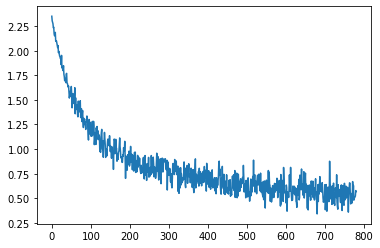

In [30]:
plt.plot(losses)

# Create a Neural Network

This is a neural network with a hidden layer.

In [35]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [36]:
model = Mnist_NN().cuda()

In [37]:
losses = [update(x, y, lr) for x,y in data.train_dl]

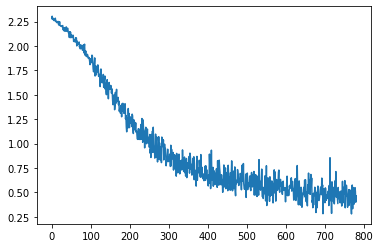

In [38]:
plt.plot(losses)

# Use Adam from Optim for Optimization Step

Using optim.Adam instead of doing the optimizer step manually.

In [39]:
def update(x, y, lr):
    #use optim adam instead
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [40]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


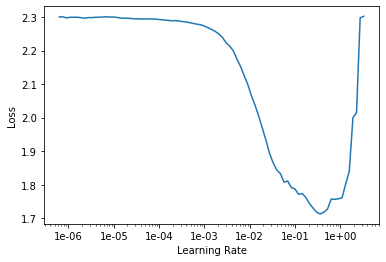

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.146531,0.134084,0.960800,00:04


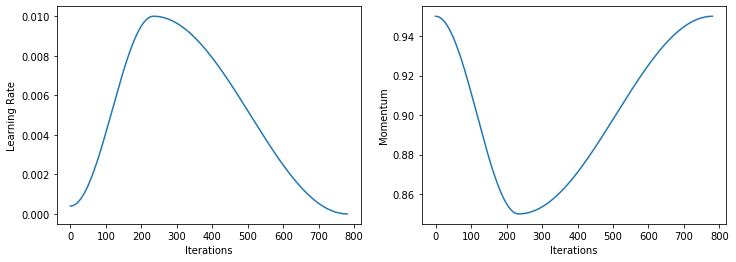

In [43]:
learn.recorder.plot_lr(show_moms=True)

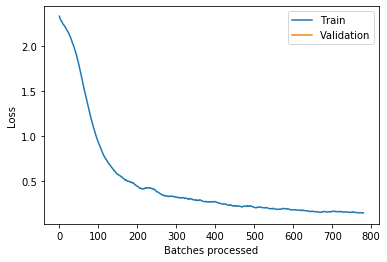

In [44]:
learn.recorder.plot_losses()